### Imports

In [2]:
# You absolutely need these
import mlflow

# You will probably need these
import pandas as pd
import numpy as np
from sklearn.pipeline import Pipeline

# This are for example purposes. You may discard them if you don't use them.
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split, TimeSeriesSplit
from sklearn.metrics import mean_absolute_error
from wind_power.dataset import InfluxDBClientWrapper, get_power_and_wind_data

In [3]:
%matplotlib widget

### The Data

In [3]:
with InfluxDBClientWrapper() as client:
    power_df, wind_df, today = get_power_and_wind_data(
        client, days=720, date="2024-03-03"
    )
power_df = power_df[["Total"]].copy()
wind_df = wind_df[["Speed", "Direction"]].copy()

InfluxDBClientError: 401: {"code":"unauthorized","message":"Unauthorized"}

In [5]:
# Joining the data
joined_dfs = power_df.join(wind_df, how="right")

# Understanding the data: EDA

It can be also useful to plot our datasets to see what relationships they might hold.

### Given

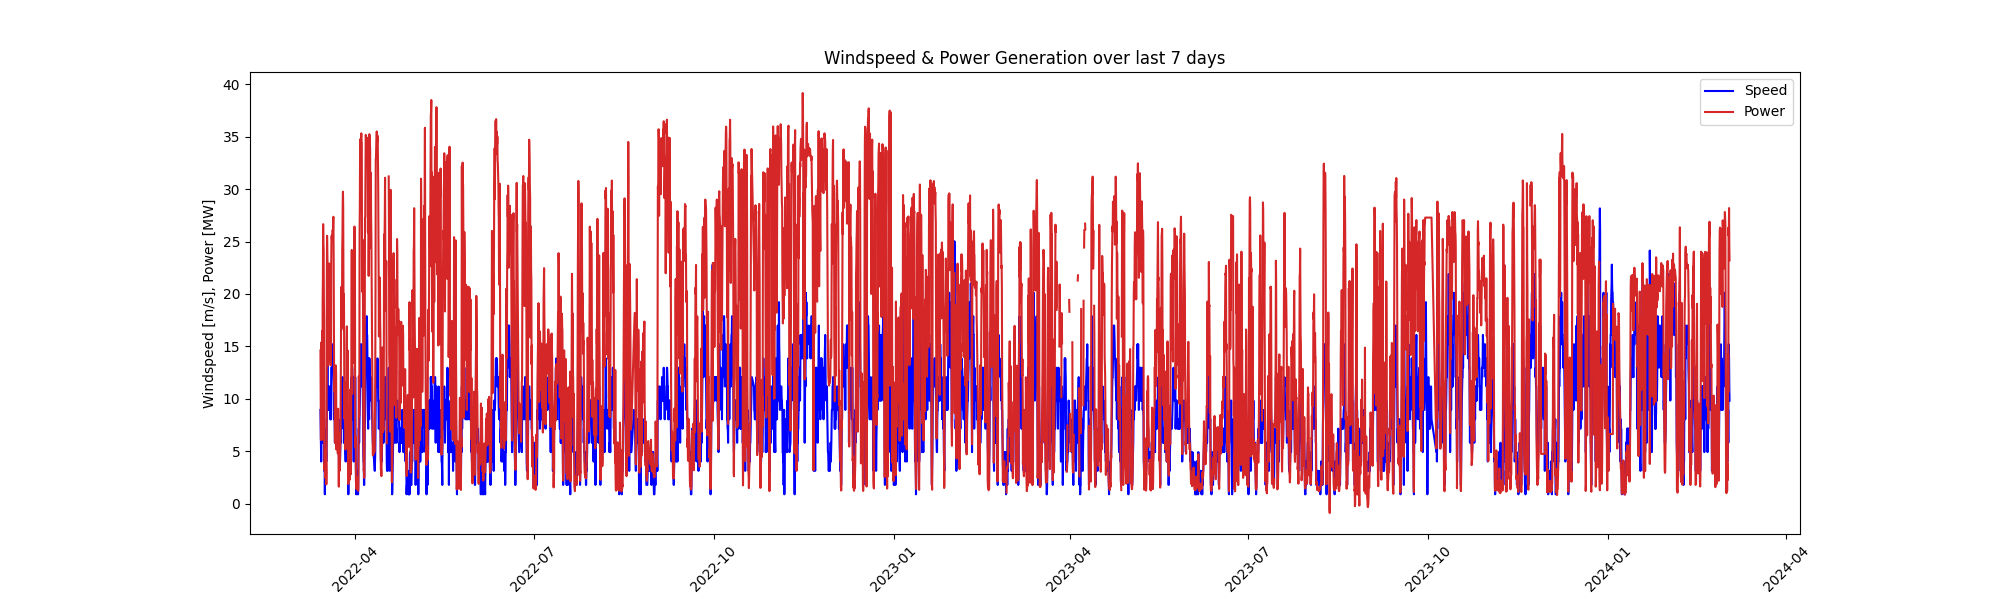

In [6]:
# Subplots
plt.figure(figsize=(20, 6))
# Speed and Power for the last 7 days
plt.plot(
    joined_dfs["Speed"], label="Speed", color="blue"
)  # Since the datasets are joined every three hours, we need the last 7 days times 24 hours diveded by 3 hours
plt.plot(
    joined_dfs["Total"], label="Power", color="tab:red"
)  # Since the datasets are joined every three hours, we need the last 7 days times 24 hours diveded by 3 hours
plt.title("Windspeed & Power Generation over last 7 days")
plt.xlabel("Time")
plt.tick_params(axis="x", labelrotation=45)
plt.ylabel("Windspeed [m/s], Power [MW]")
plt.legend()
plt.show()


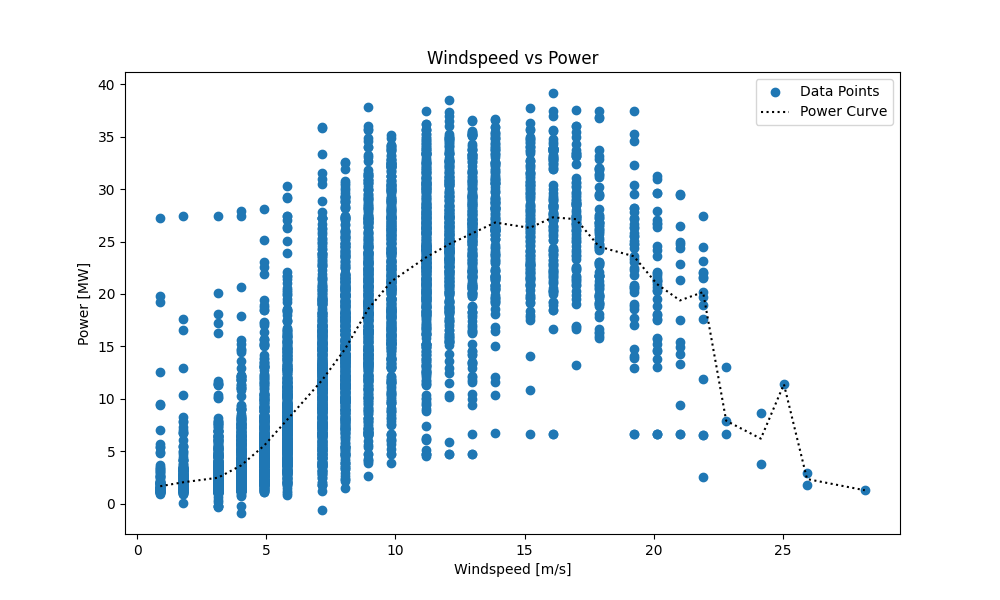

In [7]:
plt.figure(figsize=(10, 6))

# Plot Speed vs Power
plt.scatter(joined_dfs["Speed"], joined_dfs["Total"], label="Data Points")
power_curve = joined_dfs.groupby("Speed").median(numeric_only=True)["Total"]
plt.plot(power_curve.index, power_curve.values, "k:", label="Power Curve")
plt.legend()
plt.title("Windspeed vs Power")
plt.ylabel("Power [MW]")
plt.xlabel("Windspeed [m/s]")

plt.show()


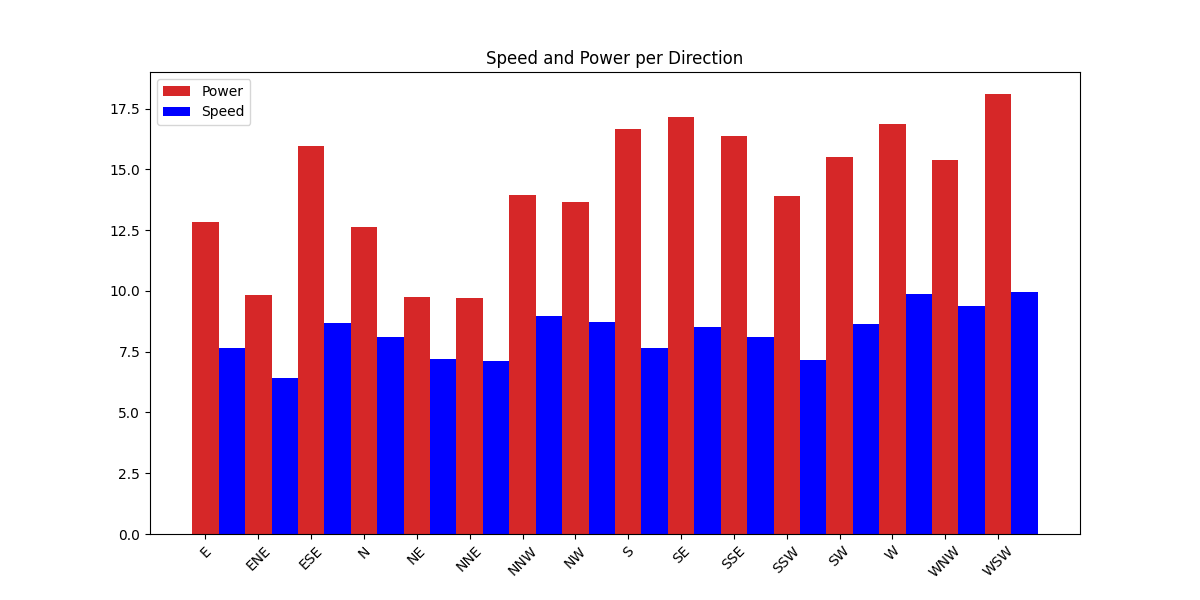

In [8]:
# Speed and Power per Wind Direction
wind_grouped_by_direction = (
    joined_dfs.groupby("Direction").mean(numeric_only=True).reset_index()
)
bar_width = 0.5
x = np.arange(len(wind_grouped_by_direction.index))

plt.figure(figsize=(12, 6))
plt.bar(x, wind_grouped_by_direction.Total, width=0.5, label="Power", color="tab:red")
plt.bar(
    x + bar_width,
    wind_grouped_by_direction.Speed,
    width=0.5,
    label="Speed",
    color="blue",
)
plt.legend()
plt.xticks(x, wind_grouped_by_direction.Direction, rotation=45)
plt.title("Speed and Power per Direction")
plt.show()


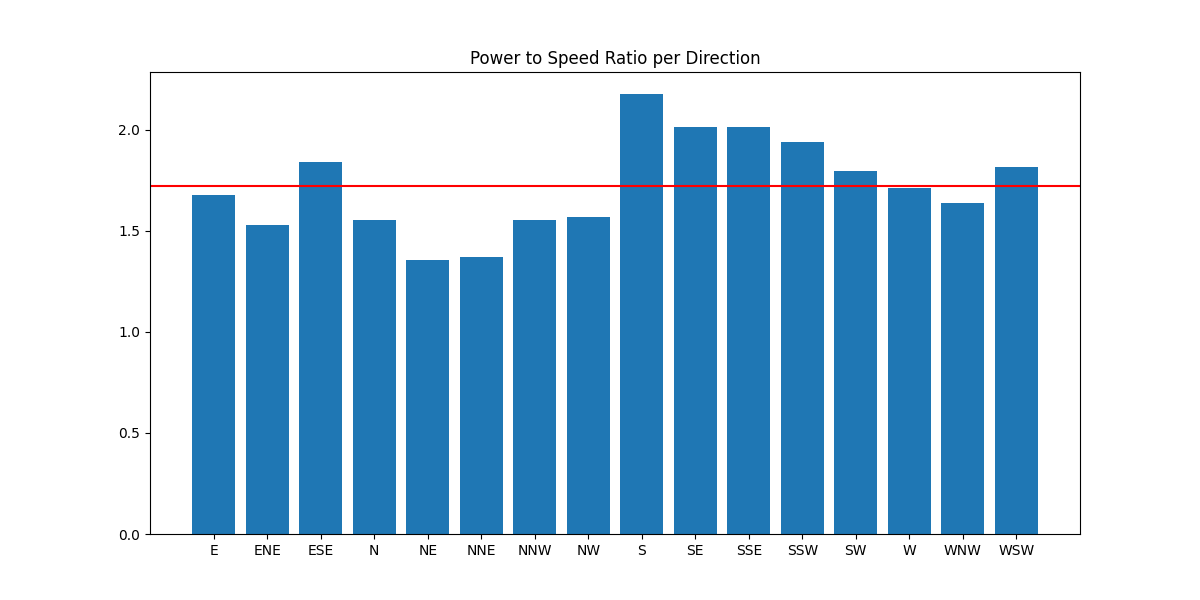

Standard Deviation of Power to Speed Ratio: 0.2364353321823762


In [9]:
# Create a difference plot
plt.figure(figsize=(12, 6))
y = wind_grouped_by_direction.Total / wind_grouped_by_direction.Speed
plt.bar(wind_grouped_by_direction.Direction, y)
# Plot horizontal line, a mean of y
plt.axhline(y.mean(), color="r", linestyle="-")
plt.title("Power to Speed Ratio per Direction")
plt.show()

# Print standard deviation of y
print("Standard Deviation of Power to Speed Ratio:", y.std())


In [10]:
# I'm not sure how to interpret this plot honestly. Saying that:
# constant = wind_grouped_by_direction.Total / wind_grouped_by_direction.Speed helps anything, I'm not sure.

In [11]:
# From that plot one could see that given an average windspeed, one could predict average power output, without considering the wind direction.
# which suggests maybe it's not that important to consider wind direction in the model.
# actually, a statistical test could be performed, because if these are means, these are normally distributed, and we could perform a t-test to see if the means are different.
# so their ratio is distributed as cauchy, so can check that later.

In [12]:
# Another check in determining the importance of wind direction is checking the correlation between wind direction and speed.abs
# Also, another one would be just plotting windspeed given different directions (using colouring) and see if there's any difference in pattern
# perhaps would be the best to draw them one vs one, but there would be 25 combinations, so that's a lot of plots.

# let's check the correlation between wind direction and speed.abs on wind_df

one_hot_encoded = pd.get_dummies(wind_df)

# compute the correlation between wind speed and each of the one-hot encoded wind directions
correlations = one_hot_encoded.apply(lambda x: joined_dfs["Speed"].corr(x))
correlations


Speed            1.000000
Direction_E     -0.040246
Direction_ENE   -0.083779
Direction_ESE    0.017074
Direction_N     -0.017899
Direction_NE    -0.061647
Direction_NNE   -0.061537
Direction_NNW    0.030730
Direction_NW     0.016657
Direction_S     -0.053175
Direction_SE     0.006536
Direction_SSE   -0.024225
Direction_SSW   -0.066709
Direction_SW     0.012911
Direction_W      0.094146
Direction_WNW    0.053127
Direction_WSW    0.109633
dtype: float64

In [13]:
# compute the correlation between wind speed and each of the one-hot encoded wind directions
correlations = one_hot_encoded.apply(lambda x: joined_dfs["Total"].corr(x))
correlations


Speed            0.738888
Direction_E     -0.048359
Direction_ENE   -0.094384
Direction_ESE    0.028604
Direction_N     -0.057463
Direction_NE    -0.111555
Direction_NNE   -0.105645
Direction_NNW   -0.025557
Direction_NW    -0.032591
Direction_S      0.051506
Direction_SE     0.068288
Direction_SSE    0.045626
Direction_SSW   -0.024511
Direction_SW     0.014440
Direction_W      0.054193
Direction_WNW    0.009989
Direction_WSW    0.096972
dtype: float64

In [14]:
pd.get_dummies(wind_df)

,Speed,Direction_E,Direction_ENE,Direction_ESE,Direction_N,Direction_NE,Direction_NNE,Direction_NNW,Direction_NW,Direction_S,Direction_SE,Direction_SSE,Direction_SSW,Direction_SW,Direction_W,Direction_WNW,Direction_WSW
time,,,,,,,,,,,,,,,,,
2022-03-14 03:00:00,8.94080,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False
2022-03-14 06:00:00,7.15264,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False
2022-03-14 09:00:00,4.91744,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False
2022-03-14 12:00:00,4.02336,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False
2022-03-14 15:00:00,5.81152,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-03-02 12:00:00,15.19936,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False
2024-03-02 15:00:00,15.19936,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
2024-03-02 18:00:00,13.85824,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False


### Let's do two quick checks - if the lag is useful and if 

##### Helpers

In [15]:
from statsmodels.graphics.tsaplots import plot_pacf


def make_lags(ts, lags, lead_time=1, name="y"):
    return pd.concat(
        {f"{name}_lag_{i}": ts.shift(i) for i in range(lead_time, lags + lead_time)},
        axis=1,
    )


def lagplot(x, y=None, shift=1, standardize=False, ax=None, **kwargs):
    from matplotlib.offsetbox import AnchoredText

    x_ = x.shift(shift)
    if standardize:
        x_ = (x_ - x_.mean()) / x_.std()
    if y is not None:
        y_ = (y - y.mean()) / y.std() if standardize else y
    else:
        y_ = x
    corr = y_.corr(x_)
    if ax is None:
        fig, ax = plt.subplots()
    scatter_kws = dict(
        alpha=0.75,
        s=3,
    )
    line_kws = dict(
        color="C3",
    )
    ax = sns.regplot(
        x=x_,
        y=y_,
        scatter_kws=scatter_kws,
        line_kws=line_kws,
        lowess=True,
        ax=ax,
        **kwargs,
    )
    at = AnchoredText(
        f"{corr:.2f}",
        prop=dict(size="large"),
        frameon=True,
        loc="upper left",
    )
    at.patch.set_boxstyle("square, pad=0.0")
    ax.add_artist(at)
    title = f"Lag {shift}" if shift > 0 else f"Lead {shift}"
    ax.set(title=f"Lag {shift}", xlabel=x_.name, ylabel=y_.name)
    return ax


def plot_lags(x, y=None, lags=6, leads=None, nrows=1, lagplot_kwargs={}, **kwargs):
    import math

    kwargs.setdefault("nrows", nrows)
    orig = leads is not None
    leads = leads or 0
    kwargs.setdefault("ncols", math.ceil((lags + orig + leads) / nrows))
    kwargs.setdefault("figsize", (kwargs["ncols"] * 2, nrows * 2 + 0.5))
    fig, axs = plt.subplots(sharex=True, sharey=True, squeeze=False, **kwargs)
    for ax, k in zip(fig.get_axes(), range(kwargs["nrows"] * kwargs["ncols"])):
        k -= leads + orig
        if k + 1 <= lags:
            ax = lagplot(x, y, shift=k + 1, ax=ax, **lagplot_kwargs)
            title = f"Lag {k + 1}" if k + 1 >= 0 else f"Lead {-k - 1}"
            ax.set_title(title, fontdict=dict(fontsize=14))
            ax.set(xlabel="", ylabel="")
        else:
            ax.axis("off")
    plt.setp(axs[-1, :], xlabel=x.name)
    plt.setp(axs[:, 0], ylabel=y.name if y is not None else x.name)
    fig.tight_layout(w_pad=0.1, h_pad=0.1)
    return fig


#### Lags

In [16]:
lags = make_lags(one_hot_encoded, 8)
correlations = lags.apply(lambda x: joined_dfs["Total"].corr(x))
correlations[abs(correlations) > 0.2]

y_lag_1  Speed    0.669340
y_lag_2  Speed    0.574933
y_lag_3  Speed    0.483517
y_lag_4  Speed    0.404800
y_lag_5  Speed    0.340834
y_lag_6  Speed    0.291643
y_lag_7  Speed    0.250956
y_lag_8  Speed    0.226251
dtype: float64

#### Rolling std deviance for each.

In [17]:
# convert wind directions to radians. Now it's categorical like E, W, N, S, ENE, ESE etc.
# so we need to convert them to degrees to be able to plot them on a circle.
# we can use the following mapping:

converstion = {
    "N": 0,
    "NNE": 22.5,
    "NE": 45,
    "ENE": 67.5,
    "E": 90,
    "ESE": 112.5,
    "SE": 135,
    "SSE": 157.5,
    "S": 180,
    "SSW": 202.5,
    "SW": 225,
    "WSW": 247.5,
    "W": 270,
    "WNW": 292.5,
    "NW": 315,
    "NNW": 337.5,
}

joined_dfs["Wx"] = joined_dfs["Direction"].transform(
    lambda x: np.cos(converstion[x] * np.pi / 180)
)
joined_dfs["Wy"] = joined_dfs["Direction"].transform(
    lambda x: np.sin(converstion[x] * np.pi / 180)
)
# if the values are close to 0, then make them 0
joined_dfs["Wx"] = joined_dfs["Wx"].transform(lambda x: 0 if abs(x) < 1e-10 else x)
joined_dfs["Wy"] = joined_dfs["Wy"].transform(lambda x: 0 if abs(x) < 1e-10 else x)
# now, these together repesent the unit vector of the wind direction

In [18]:
lags = make_lags(joined_dfs.drop(columns=["Direction"]), 8)
correlations = lags.apply(lambda x: joined_dfs["Total"].corr(x))
correlations[abs(correlations) > 0.15]

y_lag_1  Total    0.882834
         Speed    0.669340
         Wx      -0.205318
y_lag_2  Total    0.756674
         Speed    0.574933
         Wx      -0.232000
y_lag_3  Total    0.644717
         Speed    0.483517
         Wx      -0.239388
y_lag_4  Total    0.551352
         Speed    0.404800
         Wx      -0.237215
y_lag_5  Total    0.476345
         Speed    0.340834
         Wx      -0.228440
y_lag_6  Total    0.416993
         Speed    0.291643
         Wx      -0.211658
y_lag_7  Total    0.370762
         Speed    0.250956
         Wx      -0.193822
y_lag_8  Total    0.338016
         Speed    0.226251
         Wx      -0.177268
dtype: float64

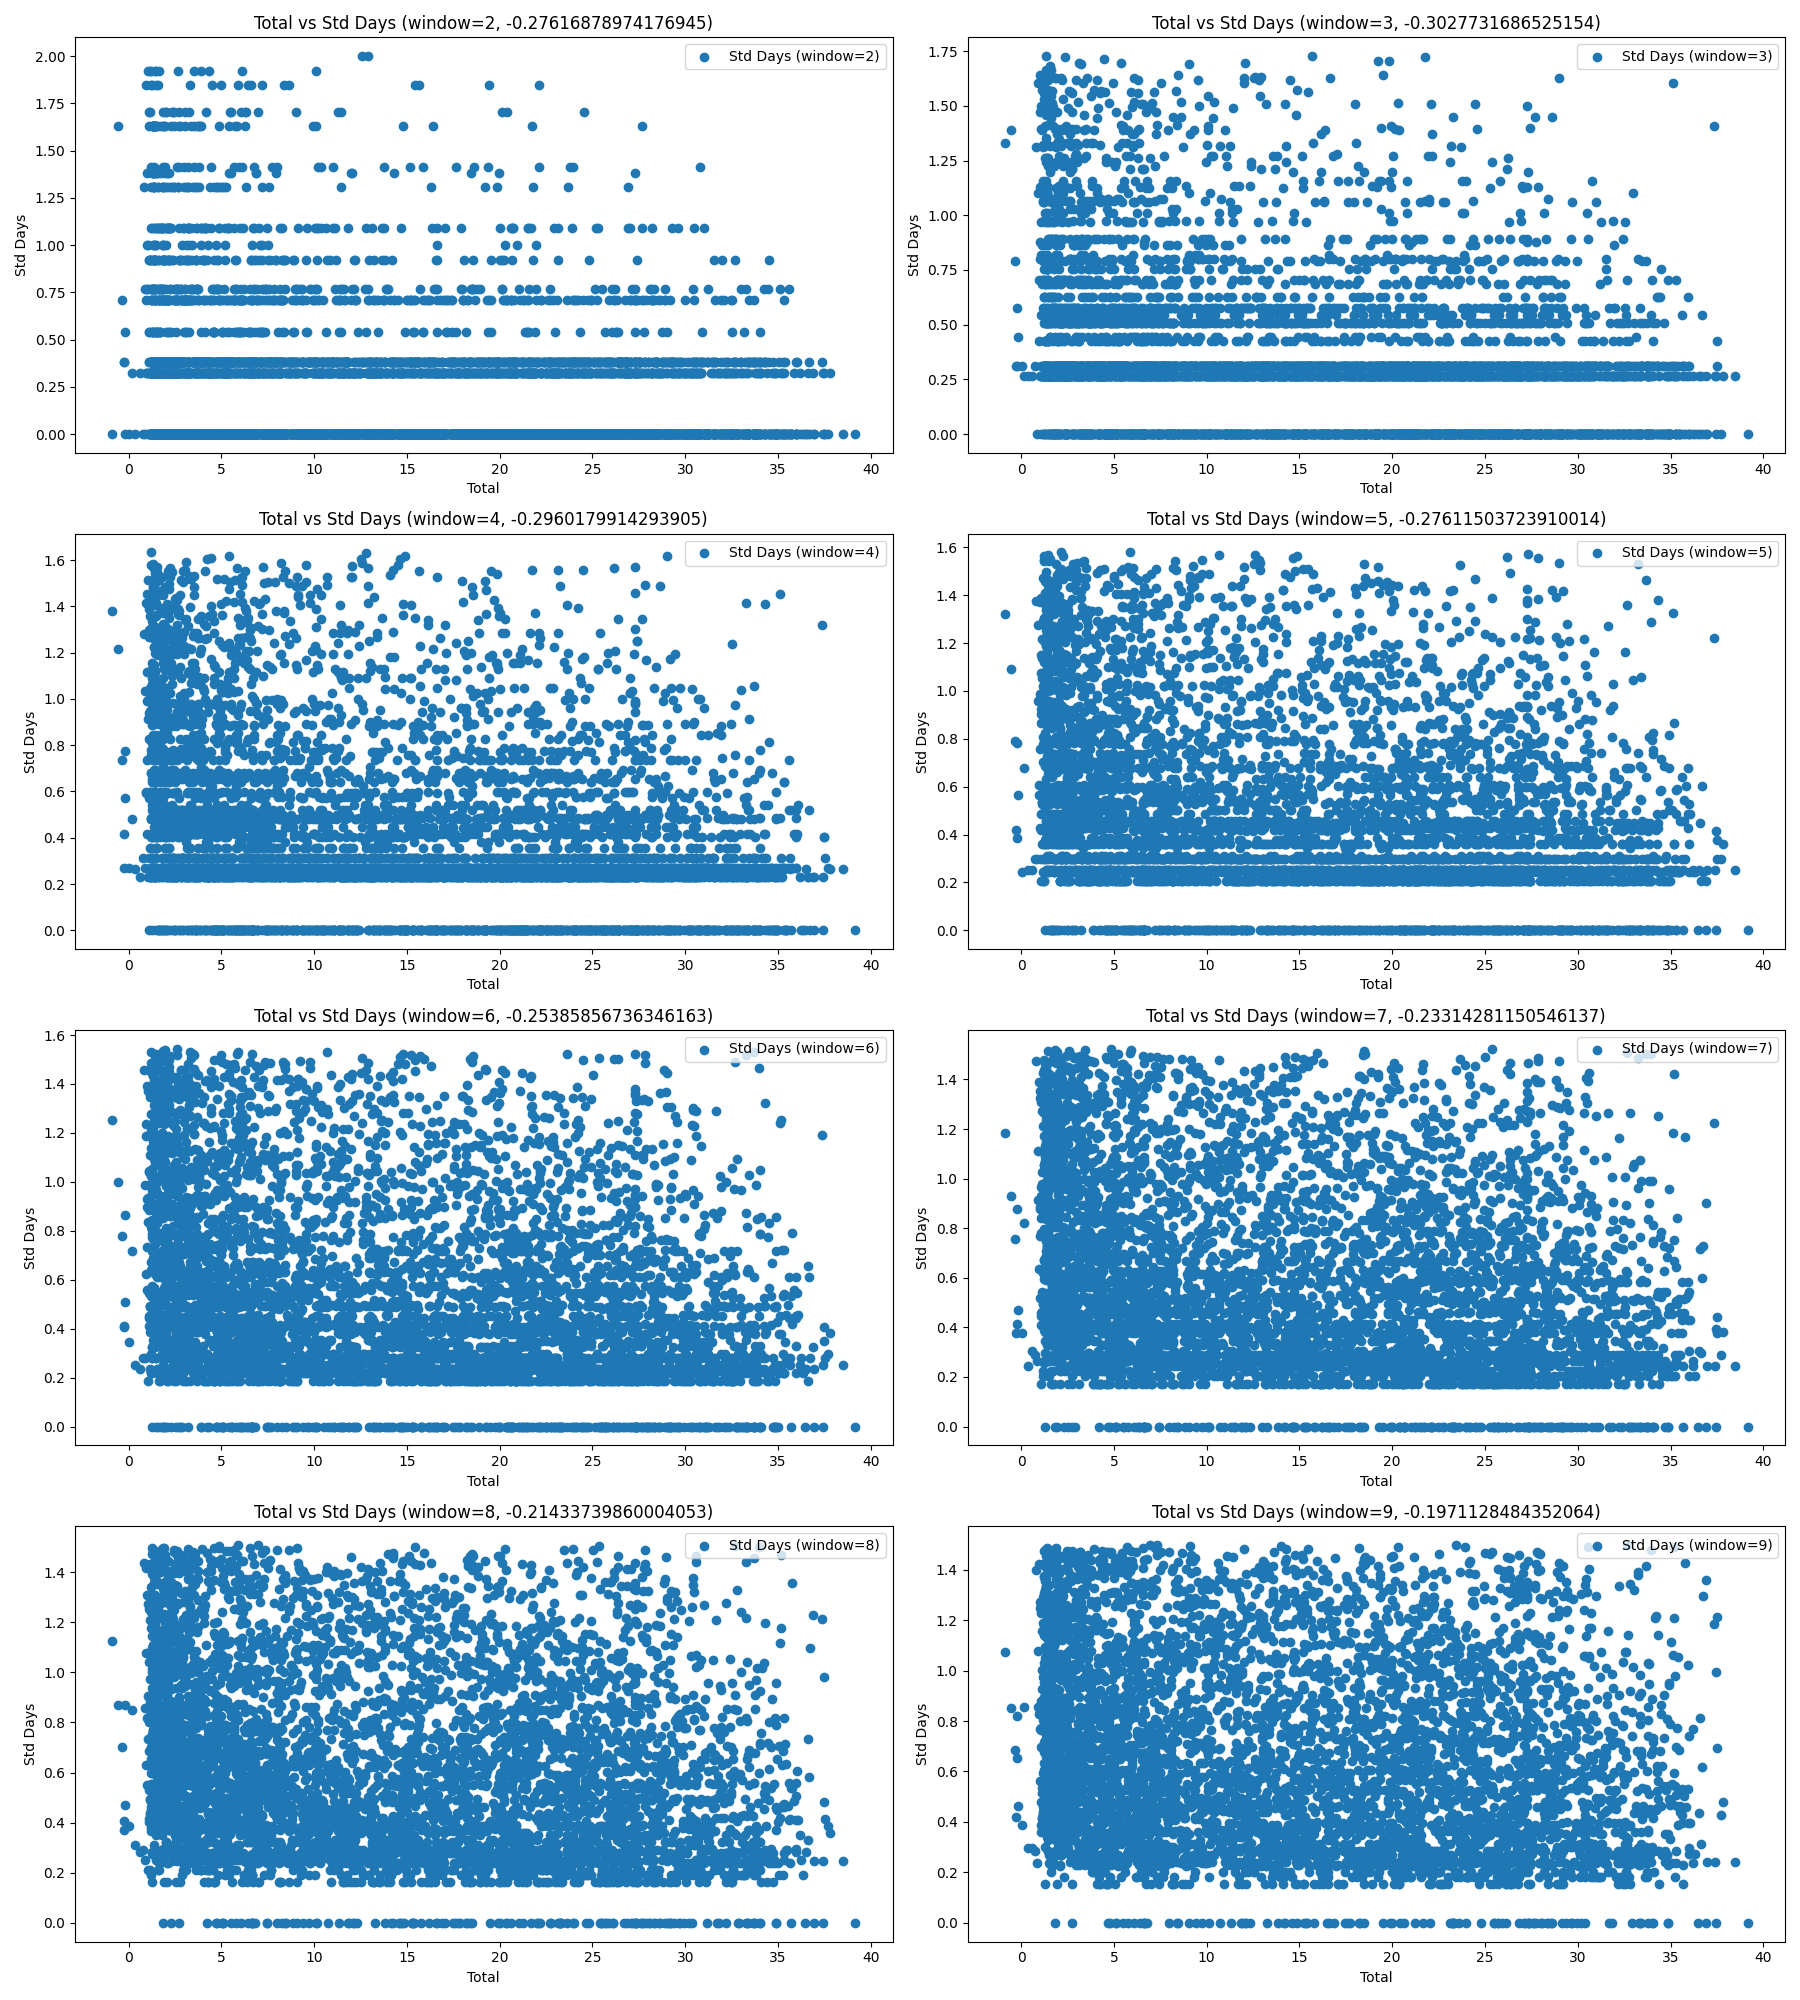

In [19]:
fig, axs = plt.subplots(4, 2, figsize=(18, 20))

for i in range(2, 10):
    std_days = (
        joined_dfs.drop(columns=["Direction", "Total", "Speed"])
        .rolling(window=i)
        .std()
        .sum(axis=1)
    )

    ax = axs[(i - 2) // 2, (i - 2) % 2]
    ax.scatter(joined_dfs["Total"], std_days, label=f"Std Days (window={i})")
    ax.set_title(
        f"Total vs Std Days (window={i}, {joined_dfs['Total'].corr(std_days)})"
    )
    ax.set_xlabel("Total")
    ax.set_ylabel("Std Days")
    ax.legend()

plt.tight_layout()
plt.show()


In [20]:
interaction_term = (
    joined_dfs.drop(columns=["Direction", "Total", "Speed"])
    .rolling(window=3)
    .std()
    .mean(axis=1)
    * joined_dfs["Speed"]
)
joined_dfs["Total"].corr(interaction_term)

0.1490540119541557

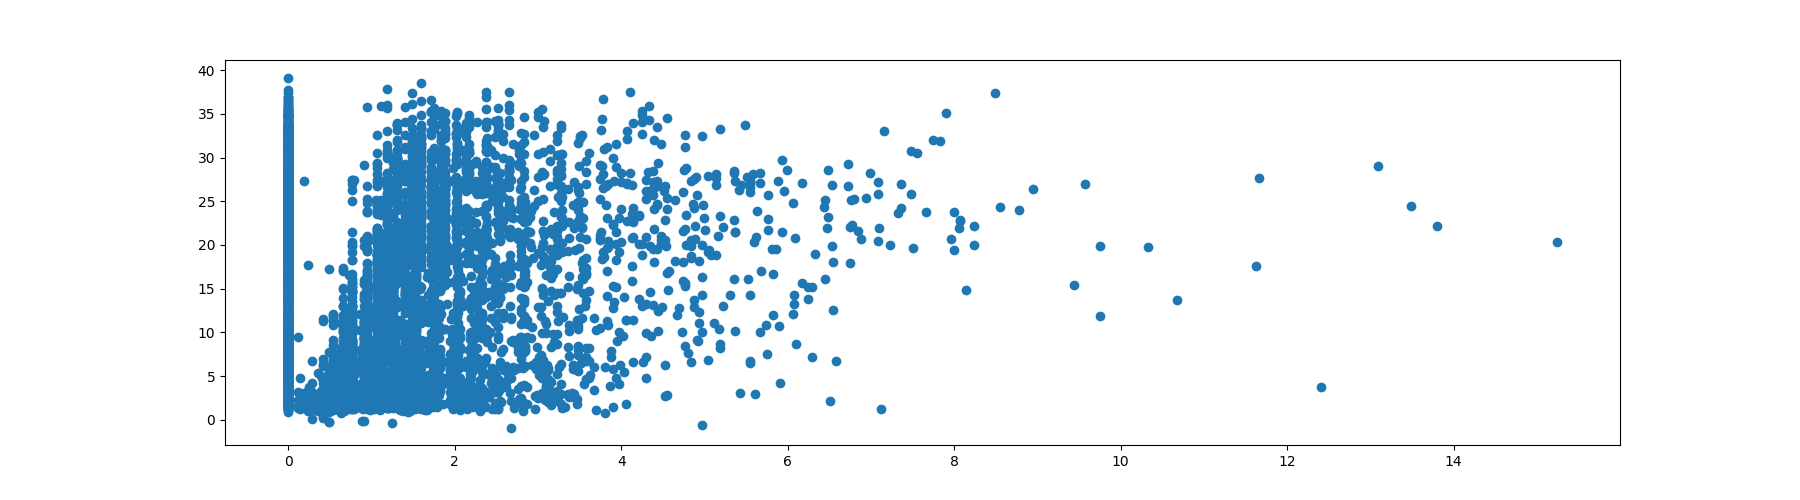

In [21]:
plt.figure(figsize=(18, 5))
plt.scatter(interaction_term, joined_dfs["Total"])
plt.show()

In [22]:
lags = make_lags(joined_dfs.drop(columns=["Direction"]), 8)
correlations = lags.apply(lambda x: joined_dfs["Total"].corr(x))
correlations[abs(correlations) > 0.15]

y_lag_1  Total    0.882834
         Speed    0.669340
         Wx      -0.205318
y_lag_2  Total    0.756674
         Speed    0.574933
         Wx      -0.232000
y_lag_3  Total    0.644717
         Speed    0.483517
         Wx      -0.239388
y_lag_4  Total    0.551352
         Speed    0.404800
         Wx      -0.237215
y_lag_5  Total    0.476345
         Speed    0.340834
         Wx      -0.228440
y_lag_6  Total    0.416993
         Speed    0.291643
         Wx      -0.211658
y_lag_7  Total    0.370762
         Speed    0.250956
         Wx      -0.193822
y_lag_8  Total    0.338016
         Speed    0.226251
         Wx      -0.177268
dtype: float64

In [23]:
joined_dfs["rolling"] = joined_dfs[["Wx", "Wy"]].rolling(3).std().mean(axis=1)

In [24]:
wind_df

,Speed,Direction
time,,
2022-03-14 03:00:00,8.94080,SSE
2022-03-14 06:00:00,7.15264,SSE
2022-03-14 09:00:00,4.91744,SSE
2022-03-14 12:00:00,4.02336,SSW
2022-03-14 15:00:00,5.81152,SSE
...,...,...
2024-03-02 12:00:00,15.19936,ENE
2024-03-02 15:00:00,15.19936,E
2024-03-02 18:00:00,13.85824,SSE


In [25]:
# checking co

In [26]:
# how to encode these features?
# As radians: imo very wrong, it's just 'sparse' ordinal encoding, for nominal data. Bad idea, though dimensionality is the smallest.
# the second: one-hot encoding: I think could do fine, especially if some dimensionality reduction would be introduced. (PCA)
# the last one: as a vector. That sound interesting, because here it should encapsulate all the necessary information in the smallest dimensionality possible.
# Even though ordinality is introduced I guess it should be ounteracted by the ordinality of the second feature, so it should be fine.
# But I'm not super sure. I will write an email to my professor asap. Gonna try with these two. Obviously here scaling shall not be applied.

# Another issue: Should one scale categorical features? In my humble opinion, yes, because these still might have different variane - that's all.
# But I need to think / talk about it haha. By default I will leave them in fact but I would do other way. But not sure. I think it's still pretty much worth it.
# OK, let's think about it later.

In [27]:
# https://web.archive.org/web/20220127105734/http://dr%C3%B8mst%C3%B8rre.dk/wp-content/wind/miller/windpower%20web/en/tour/wres/pwr.htm => super important!
# Pitfalls in Using Power Curves
# A power curve does not tell you how much power a wind turbine will produce at a certain average wind speed. You would not even be close, if you used that method!
# Remember, that the energy content of the wind varies very strongly with the wind speed, as we saw in the section on the energy in the wind. So, it matters a lot how that average came about, i.e. if winds vary a lot, or if the wind blows at a relatively constant speed.
# Also, you may remember from the example in the section on the power density function , that most of the wind energy is available at wind speeds which are twice the most common wind speed at the site.
# Finally, we need to account for the fact that the turbine may not be running at standard air pressure and temperature, and consequently make corrections for changes in the density of air.

**NOTE:** <em>These plots should already give us an intuition of the different relationships between features. It seems clear that there is a positive relationship between the wind speed and the power generation from the turbines, as we obviously suspected. But that relationship is not completely linear. Can you spot that? Finally, it seems like the power generation also depends of where the winds is coming from. Maybe this could also be a useful feature.</em> 

In [28]:
# How much data back: let's try 30, 90 days and 1 year back perhaps? Let's try with 90 days first and a year and then talk. For that I would just perform experiments
# haha :)
# More days means more data, but obviously in the past some other could be in place - I mean, climate change, global warming etc. Methaphorically speaking, data can 'expire'.

In order to plot the relationship between wind speed and power generation we have performed a very simple join with the two datasets. But since the intervals are not the same, a lot of data is discarded (<em>can you spot where in the code this happens?</em>). You may want to explore other ways to merge the data sources to minimize the loss of information.

In [29]:
### TODO -> DO SOME EXTRA EDA ON THE DATA ###

# My Part

For each model:
1. Pull data (7, 90, a year). Log time. You can also log dataset haha, to have it as a point of reference. Log the dataset on its own :)
2. Drop missing and drop outliers. (I drop missing: enough data, drop outliers - standard procedure.) Check for missing
3. Do the cross val. For 7 days, use 4 weeks. For 90 years, use the whole year. For one year, use another year.
4. Encode features and scale them appropriately. Log the way it's been done haha, including info on them.
5. Output the score.


## Step 2: Pipeline and data transformations

Now that we have our data, we need to construct the pipeline to process this data and pass it to our Machine Learning model. For this, you may find useful the Pipeline class from Scikit-Learn.

This class applies a list of transforms to your data, and pass the final state to an estimator (your model). Intermediate steps of the pipeline must be ‘transforms’, that is, they must implement fit and transform methods. The final estimator only needs to implement fit. 

The purpose of the pipeline is to assemble several steps that can be cross-validated together while setting different parameters. For this, it enables setting parameters of the various steps using their names and the parameter name separated by a '__'. 

You can find more information about Scikit-Learn's Pipeline [here](https://scikit-learn.org/stable/modules/compose.html#pipeline).

In [30]:
from wind_power.features import ensure_non_negative

joined_dfs = joined_dfs.dropna().drop(columns="Direction")
joined_dfs = ensure_non_negative(joined_dfs)

In [31]:
joined_dfs

,Total,Speed,Wx,Wy,rolling
time,,,,,
2022-03-14 09:00:00,6.077117,4.91744,0.000000,0.382683,0.000000
2022-03-14 12:00:00,6.792117,4.02336,0.000000,0.000000,0.220942
2022-03-14 15:00:00,15.385117,5.81152,0.000000,0.382683,0.220942
2022-03-14 18:00:00,8.401117,7.15264,0.000000,0.382683,0.220942
2022-03-14 21:00:00,14.859118,7.15264,0.000000,0.000000,0.132445
...,...,...,...,...,...
2024-03-02 12:00:00,26.352273,15.19936,0.382683,0.923880,0.220942
2024-03-02 15:00:00,25.518434,15.19936,0.000000,1.000000,0.213316
2024-03-02 18:00:00,28.194990,13.85824,0.000000,0.382683,0.504148


#### Example

In [32]:
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.linear_model import ElasticNet, Lasso, LinearRegression, Ridge
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
import numpy as np

# Split the data
train_size = int(len(joined_dfs.dropna()) * 0.8)
train, test = (
    joined_dfs.dropna().iloc[:train_size],
    joined_dfs.dropna().iloc[train_size:],
)

# Prepare the features and target
poly = PolynomialFeatures(degree=3)
X_train_poly = poly.fit_transform(train[["Speed"]])
X_test_poly = poly.transform(test[["Speed"]])

# Concatenate polynomial features with rolling feature
X_train = np.concatenate(
    (X_train_poly, X_train_poly * np.array(train["rolling"])[:, np.newaxis]), axis=1
)
X_test = np.concatenate(
    (X_test_poly, X_test_poly * np.array(test["rolling"])[:, np.newaxis]), axis=1
)

# Scale the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

y_train = train["Total"]
y_test = test["Total"]

# Train the model
model = Ridge()
model.fit(X_train_scaled, y_train)

# Predict and calculate RMSE
y_pred = model.predict(X_test_scaled)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print(f"RMSE: {rmse}")

RMSE: 6.7761591064753235


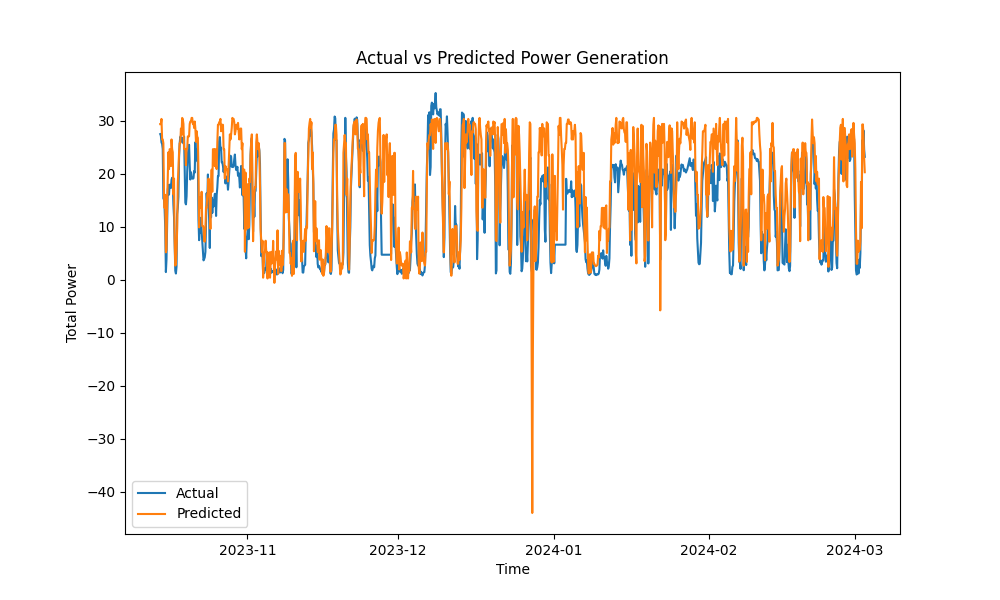

In [33]:
plt.figure(figsize=(10, 6))
plt.plot(y_test.index, y_test, label="Actual")
plt.plot(y_test.index, y_pred, label="Predicted")
plt.xlabel("Time")
plt.ylabel("Total Power")
plt.title("Actual vs Predicted Power Generation")
plt.legend()
plt.show()

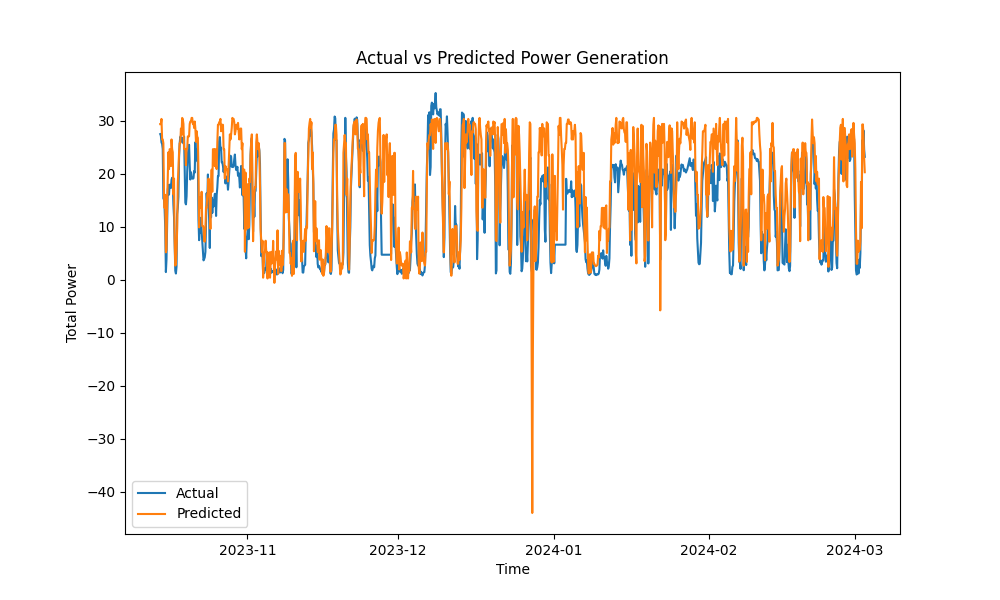

In [34]:
plt.figure(figsize=(10, 6))
plt.plot(y_test.index, y_test, label="Actual")
plt.plot(y_test.index, y_pred, label="Predicted")
plt.xlabel("Time")
plt.ylabel("Total Power")
plt.title("Actual vs Predicted Power Generation")
plt.legend()
plt.show()

In [35]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.linear_model import Ridge
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import numpy as np

# Split the data
train_size = int(len(joined_dfs.dropna()) * 0.8)
train, test = (
    joined_dfs.dropna().iloc[:train_size],
    joined_dfs.dropna().iloc[train_size:],
)

# Prepare the features and target
X_train = train[["Speed", "rolling"]]
X_test = test[["Speed", "rolling"]]
y_train = train["Total"]
y_test = test["Total"]

# Define the pipeline
pipeline = Pipeline(
    [
        ("poly_features", PolynomialFeatures(degree=3)),
        ("scaler", StandardScaler()),
        ("ridge_regression", Ridge()),
    ]
)

# Train the model
pipeline.fit(X_train, y_train)

# Predict and calculate RMSE
y_pred = pipeline.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print(f"RMSE: {rmse}")


RMSE: 6.722302933713771


# Step 3: Tracking your experiments with MLFlow

We have a working model with a certain accuracy. But wouldn't it be better to try different parameters and different models before deciding for one? <br><br>
This is exactly what we will do using the MLFlow library. MLflow is an open source platform to manage the ML lifecycle, including experimentation, reproducibility, deployment, and a central model registry. This will allow us for easy comparison of all our model experiments. <br>

**NOTE:**<em> Don't forget to check the [MLFlow documentation](https://mlflow.org/docs/latest/index.html) to learn more about the library.</em>

#### Example

When using MLFlow locally to log our experiments, we need to start a "local server". We can do this easily by running the following in our command line interface:

```
mlflow server
```

For example, using PowerShell, it should look like this:

![MLFlow Server](https://github.com/ginofazzi/testing/raw/0d3ffce58ee12f6d1c86b6a3c2ac628314e7b82e/mlflow_server.png)

In this example, we can see that the server is located at our localhost 127.0.0.1, port 5000. We will use this information to indicate MLFlow where to save our experiment details.

In [36]:
from sklearn.metrics import mean_squared_error
import numpy as np

# Define the TimeSeriesSplit
tscv = TimeSeriesSplit(n_splits=104)

# Prepare the features and target
X = joined_dfs[["Speed", "rolling"]]
y = joined_dfs["Total"]

# Initialize a list to store RMSE values and corresponding indices
rmse_values = []
kfold_indices = []

# Perform TimeSeriesSplit cross-validation
for train_index, test_index in tscv.split(X):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    # Define the pipeline
    pipeline = Pipeline(
        [
            ("poly_features", PolynomialFeatures(degree=3)),
            ("scaler", StandardScaler()),
            ("ridge_regression", Ridge()),
        ]
    )

    # Train the model
    pipeline.fit(X_train, y_train)

    # Predict and calculate RMSE
    y_pred = pipeline.predict(X_test)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    rmse_values.append(rmse)
    kfold_indices.append((train_index, test_index))

# Compute the average RMSE
average_rmse = np.mean(rmse_values)
print(f"Average RMSE across 104 splits: {average_rmse}")

# Get the 10 best k-folds based on RMSE


Average RMSE across 104 splits: 5.550627124422789


In [37]:
best_kfolds = sorted(zip(rmse_values, kfold_indices))[:3]
# Print the 10 best k-folds
for i, (rmse, (train_index, test_index)) in enumerate(best_kfolds, 1):
    print(f"Fold {i}: RMSE = {rmse}")
    print(f"Train indices: {len(train_index) / joined_dfs.shape[0] * 720}")
    print(f"Test indices: {len(test_index)}")
    print()

Fold 1: RMSE = 2.4405155555771274
Train indices: 440.4443635039155
Test indices: 52

Fold 2: RMSE = 2.9809790185982123
Train indices: 160.888727007831
Test indices: 52

Fold 3: RMSE = 2.994063874289229
Train indices: 501.8102349298852
Test indices: 52



In [38]:
from sklearn.metrics import mean_squared_error
import numpy as np

# Define the TimeSeriesSplit
tscv = TimeSeriesSplit(n_splits=104)

# Prepare the features and target
X = joined_dfs[["Speed", "rolling"]]
y = joined_dfs["Total"]

# Initialize a list to store RMSE values and corresponding indices
rmse_values = []
kfold_indices = []

# Perform TimeSeriesSplit cross-validation
for train_index, test_index in tscv.split(X):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    best_rmse = float("inf")
    best_model = None
    best_params = None

    for model in [Ridge(), Lasso()]:
        for degree in [3, 4]:
            # Define the pipeline
            pipeline = Pipeline(
                [
                    ("poly_features", PolynomialFeatures(degree=degree)),
                    ("scaler", StandardScaler()),
                    (model.__class__.__name__.lower(), model),
                ]
            )

            # Train the model
            pipeline.fit(X_train, y_train)

            # Predict and calculate RMSE
            y_pred = pipeline.predict(X_test)
            rmse = np.sqrt(mean_squared_error(y_test, y_pred))

            if rmse < best_rmse:
                best_rmse = rmse
                best_model = model
                best_params = {"model": model.__class__.__name__, "degree": degree}

    rmse_values.append(best_rmse)
    kfold_indices.append((train_index, test_index))

# Compute the average RMSE
average_rmse = np.mean(rmse_values)
print(f"Average RMSE across 104 splits: {average_rmse}")

# Get the 3 best k-folds based on RMSE
best_kfolds = sorted(zip(rmse_values, kfold_indices))[:1]
for i, (rmse, (train_index, test_index)) in enumerate(best_kfolds, 1):
    print(f"Fold {i}: RMSE = {rmse}")
    print(f"Train indices: {len(train_index) / joined_dfs.shape[0] * 720}")
    print(f"Test indices: {len(test_index)}")
    print()


Average RMSE across 104 splits: 5.4045620299754855
Fold 1: RMSE = 2.4405155555771274
Train indices: 440.4443635039155
Test indices: 52



In [39]:
best_kfolds = sorted(zip(rmse_values, kfold_indices))[:3]
# Print the 10 best k-folds
for i, (rmse, (train_index, test_index)) in enumerate(best_kfolds, 1):
    print(f"Fold {i}: RMSE = {rmse}")
    print(f"Train indices: {len(train_index) / joined_dfs.shape[0] * 720}")
    print(f"Test indices: {len(test_index)}")
    print()

Fold 1: RMSE = 2.4405155555771274
Train indices: 440.4443635039155
Test indices: 52

Fold 2: RMSE = 2.938207297925828
Train indices: 501.8102349298852
Test indices: 52

Fold 3: RMSE = 2.9809790185982123
Train indices: 160.888727007831
Test indices: 52



In [69]:
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import TimeSeriesSplit, ParameterGrid
from sklearn.metrics import mean_squared_error
import numpy as np
import pandas as pd
from sklearn.pipeline import FunctionTransformer, Pipeline
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.linear_model import Ridge, Lasso, LinearRegression

# Define the TimeSeriesSplit
tscv = TimeSeriesSplit(n_splits=104)

# Prepare the features and target
X = joined_dfs[["Speed", "rolling"]]
y = joined_dfs["Total"]

# Define the parameter grid
param_grid = {
    "model_classname": [Ridge, Lasso, LinearRegression],
    "degree": [2, 3, 4],
    "direction": ["PolyInt", "InteractionOnly", "Drop"],
}

# Generate all parameter combinations
grid = list(ParameterGrid(param_grid))

# Initialize a list to store results
results = []


def rolling_interaction(df: pd.DataFrame):
    cols_to_multiply = df.columns.drop("rolling")
    df_cp = df.copy()
    df_cp[cols_to_multiply] = df[cols_to_multiply].mul(df["rolling"], axis=0)
    return df_cp


# Perform TimeSeriesSplit cross-validation and iterate over all parameter combinations
# for skipped, _ in tscv.split(X):
    # data = X.iloc[len(skipped):]
for train_index, test_index in tscv.split(X):
    for params in grid:
        direction = params["direction"]
        # Use full feature set or drop 'rolling' based on the 'direction' flag
        data = (
            X.drop(columns=["rolling"])
            if direction == "Drop"
            else X
        )

        X_train, X_test = data.iloc[train_index], data.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]

        # Instantiate the model from the given class
        model = params["model_classname"]()
        degree = params["degree"]
        model_name = model.__class__.__name__.lower()

        # Define the pipeline
        ct = ColumnTransformer(
            [
                (
                    "poly_features",
                    PolynomialFeatures(degree=degree),
                    ["Speed"] + (['rolling'] if direction=="PolyInt" else [])
                )
            ],
            remainder='passthrough',
            verbose_feature_names_out=False
        )
        ct.set_output(transform='pandas')
        steps = [("poly_features", ct)]
        steps += (
            [("interaction", FunctionTransformer(rolling_interaction))]
            if direction=="InteractionOnly"
            else []
        )
        steps += [
            ("scaler", StandardScaler()),
            (model_name, model),
        ]
        pipeline = Pipeline(steps)

        # Train the pipeline
        pipeline.fit(X_train, y_train)

        # Predict and calculate RMSE
        y_pred = pipeline.predict(X_test)
        rmse = np.sqrt(mean_squared_error(y_test, y_pred))

        # Store the results
        results.append(
            {
                "model_classname": model_name,
                "degree": degree,
                "direction": direction,
                "rmse": rmse,
                "len": len(train_index)
            }
        )

# Convert results to a DataFrame for better visualization
results_df = pd.DataFrame(results)

# Compute the average RMSE for each parameter combination

In [70]:

average_rmse = (
    results_df.groupby(["model_classname", "degree", "direction"])[["rmse"]]
    .mean()
    .reset_index()
)
print(average_rmse)

# Get the best parameter combination based on RMSE
best_params = average_rmse.loc[average_rmse["rmse"].idxmin()]
print(f"Best parameters: {best_params}")
# print(f"Index training length {}")


# Also print the overall best result

     model_classname  degree        direction      rmse
0              lasso       2             Drop  6.300398
1              lasso       2  InteractionOnly  8.339240
2              lasso       2          PolyInt  6.300398
3              lasso       3             Drop  6.300398
4              lasso       3  InteractionOnly  8.358144
5              lasso       3          PolyInt  6.300353
6              lasso       4             Drop  6.271217
7              lasso       4  InteractionOnly  8.358144
8              lasso       4          PolyInt  6.271172
9   linearregression       2             Drop  5.884356
10  linearregression       2  InteractionOnly  8.169403
11  linearregression       2          PolyInt  5.825604
12  linearregression       3             Drop  5.594542
13  linearregression       3  InteractionOnly  7.784425
14  linearregression       3          PolyInt  5.578197
15  linearregression       4             Drop  5.506244
16  linearregression       4  InteractionOnly  7

In [71]:
results_df.sort_values(by='rmse')[:15]

,model_classname,degree,direction,rmse,len
1727,linearregression,4,Drop,2.239336,3359
1721,linearregression,4,PolyInt,2.355971,3359
1725,ridge,4,Drop,2.380863,3359
1718,linearregression,3,Drop,2.384413,3359
1716,ridge,3,Drop,2.408608,3359
1712,linearregression,3,PolyInt,2.417241,3359
1710,ridge,3,PolyInt,2.440516,3359
1719,ridge,4,PolyInt,2.537391,3359
1970,linearregression,4,Drop,2.661301,3827
1961,linearregression,3,Drop,2.704660,3827


# I think the better way to do it would be to compare across all possible time splits etc.

In [ ]:
from dotenv import load_dotenv
load_dotenv()
mlflow.set_tracking_uri("https://dagshub.com/PLtier/a1_lsda2025.mlflow")

NameError: name 'mlflow' is not defined

In [ ]:
#TODO: handle signatures explicitly.
import mlflow
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import TimeSeriesSplit, ParameterGrid
from sklearn.metrics import mean_squared_error
import numpy as np
import pandas as pd
from sklearn.pipeline import FunctionTransformer, Pipeline
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.linear_model import Ridge, Lasso, LinearRegression

tscv = TimeSeriesSplit(n_splits=104)
X = joined_dfs[["Speed", "rolling"]]
y = joined_dfs["Total"]

param_grid = {
    "model_classname": [Ridge, Lasso, LinearRegression],
    "degree": [2, 3, 4],
    "direction": ["PolyInt", "InteractionOnly", "Drop"],
}
grid = list(ParameterGrid(param_grid))

def rolling_interaction(df: pd.DataFrame):
    cols_to_multiply = df.columns.drop("rolling")
    df_cp = df.copy()
    df_cp[cols_to_multiply] = df[cols_to_multiply].mul(df["rolling"], axis=0)
    return df_cp


mlflow.set_experiment(experiment_name= "lsda")
for params in grid:
    with mlflow.start_run():
        direction = params["direction"]
        data = X.drop(columns=["rolling"]) if direction == "Drop" else X
        model = params["model_classname"]()
        degree = params["degree"]
        model_name = model.__class__.__name__.lower()
        ct = ColumnTransformer(
            [("poly_features", PolynomialFeatures(degree=degree), ["Speed"] + (["rolling"] if direction == "PolyInt" else []))],
            remainder="passthrough",
            verbose_feature_names_out=False
        )
        ct.set_output(transform="pandas")
        steps = [("poly_features", ct)]
        if direction == "InteractionOnly":
            steps += [("interaction", FunctionTransformer(rolling_interaction))]
        steps += [("scaler", StandardScaler()), (model_name, model)]
        pipeline = Pipeline(steps)

        subresults=[]
        
        for train_index, test_index in tscv.split(X):
            X_train, X_test = data.iloc[train_index], data.iloc[test_index]
            y_train, y_test = y.iloc[train_index], y.iloc[test_index]
            pipeline.fit(X_train, y_train)
            y_pred = pipeline.predict(X_test)
            rmse = np.sqrt(mean_squared_error(y_test, y_pred))
            subresults.append({
                        "model_classname": model_name,
                        "degree": degree,
                        "direction": direction,
                        "rmse": rmse,
                        "n_train_index": len(train_index),
                    })
            
        subresults_df = pd.DataFrame(subresults).sort_values(by='rmse')[:10]
        rmse = subresults_df['rmse'].mean()
        n = int(subresults_df['n_train_index'].mean())
        
        mlflow.log_param("model_classname", model_name)
        mlflow.log_param("degree", degree)
        mlflow.log_param("direction", direction)
        mlflow.log_metric("top_10_avg_rmse", rmse)
        mlflow.log_param("top_10_training_length", n)
        mlflow.sklearn.log_model(pipeline, "pipeline")

2025/03/10 11:31:18 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run vaunted-whale-228 at: https://dagshub.com/PLtier/a1_lsda2025.mlflow/#/experiments/6/runs/f469147da4ff45878e80ce6c89c30f7c
🧪 View experiment at: https://dagshub.com/PLtier/a1_lsda2025.mlflow/#/experiments/6
